In [ ]:
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Getting Started with the Vertex AI PaLM API & Python SDK

<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/generative-ai/blob/main/language/intro_palm_api.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Google Colaboratory logo"><br> Run in Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://github.com/GoogleCloudPlatform/generative-ai/blob/main/language/intro_palm_api.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo"><br> View on GitHub
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/generative-ai/blob/main/language/intro_palm_api.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo"><br> Open in Vertex AI Workbench
    </a>
  </td>
</table>


### Overview
We will cover below PaLM2 Foundation models APIs for this notebook
1. Text-bsion
2. Chat-bison
3. Embeddings API
4. Code-bison


### Costs
This tutorial uses billable components of Google Cloud:

* Vertex AI Generative AI Studio

Learn about [Vertex AI pricing](https://cloud.google.com/vertex-ai/pricing),
and use the [Pricing Calculator](https://cloud.google.com/products/calculator/)
to generate a cost estimate based on your projected usage.

## Getting Started

### Install Vertex AI SDK

In [1]:
!pip install google-cloud-aiplatform --upgrade --user

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.0/321.0 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 18.3 MB/s eta 0:00:00
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


**Colab only:** Uncomment the following cell to restart the kernel or use the button to restart the kernel. For Vertex AI Workbench you can restart the terminal using the button on top.

In [1]:
# # Automatically restart kernel after installs so that your environment can access the new packages
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

### Authenticating your notebook environment
* If you are using **Colab** to run this notebook, uncomment the cell below and continue.
* If you are using **Vertex AI Workbench**, check out the setup instructions [here](https://github.com/GoogleCloudPlatform/generative-ai/tree/main/setup-env).

In [1]:
from google.colab import auth
auth.authenticate_user()

## Vertex AI PaLM API models

The Vertex AI PaLM API enables you to test, customize, and deploy instances of Google’s large language models (LLM) called as PaLM,  so that you can leverage the capabilities of PaLM in your applications.

### Model naming scheme
Foundation model names have three components: use case, model size, and version number. The naming convention is in the format:  
`<use case>-<model size>@<version number>`

For example, text-bison@001 represents the Bison text model, version 001.

The model sizes are as follows:
- **Bison**: The best value in terms of capability and cost.
- **Gecko**: The smallest and cheapest model for simple tasks.

### Available models

The Vertex AI PaLM API currently supports five models:

*   `text-bison@001` : Fine-tuned to follow natural language instructions and is suitable for a variety of language tasks.
*   `chat-bison@001` : Fine-tuned for multi-turn conversation use cases like building a chatbot.
*   `textembedding-gecko@001` : Returns model embeddings for text inputs.

* `code-bison@001`: A model fine-tuned to generate code based on a natural language description of the desired code. For example, it can generate a unit test for a function.


You can find more information about the properties of these [foundational models in the Generative AI Studio documentation](https://cloud.google.com/vertex-ai/docs/generative-ai/learn/models#foundation_models).


### Import libraries

**Colab only:** Uncomment the following cell to initialize the Vertex AI SDK. For Vertex AI Workbench, you don't need to run this.  

In [2]:
import vertexai

PROJECT_ID = ""  # @param {type:"string"}
vertexai.init(project=PROJECT_ID, location="us-central1")

In [30]:
import pandas as pd
import seaborn as sns
from IPython.display import Markdown, display
from sklearn.metrics.pairwise import cosine_similarity
from vertexai.language_models import TextGenerationModel, \
                                     TextEmbeddingModel, \
                                     ChatModel, \
                                     InputOutputTextPair, \
                                     CodeGenerationModel \


## Text generation with `text-bison@001`

The text generation model from PaLM API that you will use in this notebook is `text-bison@001`.
It is fine-tuned to follow natural language instructions and is suitable for a variety of language tasks, such as:

- Classification
- Sentiment analysis
- Entity extraction
- Extractive question-answering
- Summarization
- Re-writing text in a different style
- Ad copy generation
- Concept ideation
- Concept simplification

#### Load model

In [4]:
generation_model = TextGenerationModel.from_pretrained("text-bison@001")

#### Prompt design
Prompt design is the process of creating prompts that elicit the desired response from a language model. Prompt design is an important part of using language models because it allows non-specialists to control the output of the model with minimal overhead. By carefully crafting the prompts, you can nudge the model to generate a desired result. Prompt design can be an efficient way to experiment with adapting an LLM for a specific use case. The iterative process of repeatedly updating prompts and assessing the model’s responses is sometimes called prompt engineering.

#### Hello PaLM

Create your first prompt and send it to the text generation model.

In [5]:
prompt = "What is a generative AI model?"

response = generation_model.predict(prompt=prompt)

print(response.text)

A large language model (LLM) is a type of artificial intelligence (AI) model that can understand and generate human language. LLMs are trained on massive datasets of text and code, and they can learn to perform a wide variety of tasks, such as translating languages, writing different kinds of creative content, and answering your questions in an informative way.

LLMs are still under development, but they have the potential to revolutionize many industries. For example, LLMs could be used to create more accurate and personalized customer service experiences, to help doctors diagnose and treat diseases, and to even write entire books and movies.




#### Try out your own prompt

- What are the biggest challenges facing the healthcare industry?
- What are the latest developments in the automotive industry?
- What are the biggest opportunities in the retail industry?
- (Try your own prompts!)

In [6]:
prompt = """<enter your prompt>""" # try your own prompt

response = generation_model.predict(prompt=prompt)

print(response.text)

1. **Artificial intelligence**
2. **Machine learning**
3. **Blockchain**
4. **Virtual reality**
5. **Augmented reality**
6. **5G**
7. **Edge computing**
8. **Internet of things**
9. **Self-driving cars**
10. **Wearables**


#### Prompt templates

Prompt templates are useful if you have found a good way to structure your prompt that you can re-use. This can be also be helpful in limiting the open-endedness of freeform prompts. There are many ways to implement prompt templates, and below is just one example using f-strings.

In [31]:
my_industry = "financial" # try changing this to a different industry

response = generation_model.predict(
    prompt=f"""Create a numbered list of 10 items. Each item in the list should
    be a trend in the {my_industry} industry.

    Each trend should be less than 5 words."""
)

print(response.text)

1. **Artificial intelligence**
2. **Blockchain**
3. **Cryptocurrency**
4. **Data analytics**
5. **Fintech**
6. **Insurtech**
7. **Machine learning**
8. **Personalization**
9. **RegTech**
10. **Sustainability**


### Model parameters for `text-bison@001`

You can customize how the PaLM API behaves in response to your prompt by using the following parameters for `text-bison@001`:

 - `temperature`: higher means more "creative" responses
 - `max_output_tokens`: sets the max number of tokens in the output
 - `top_p`: higher means it will pull from more possible next tokens, based on cumulative probability
 - `top_k`: higher means it will sample from more possible next tokens

The section below covers each parameter and how to use them.

If you run the following cell multiple times, it should always return the same response, as `temperature=0` is deterministic.

In [28]:
#Try changing the below values and re run the cells to see different generated responses.

temp_val = 0.0  #parameter (range: 0.0 - 1.0, default 0.2). A temperature of 0 is deterministic: the highest probability response is always selected. For most use cases, try starting with a temperature of 0.2.
max_output_tokens_val = 128  #range  parameter (range: 1 - 1024, default 128)
top_p_val = 0.1  #range parameter (range: 0.0 - 1.0, default 0.95)
top_k_val = 40  #range parameter (range: 0.0 - 40, default 40)
prompt_temperature = "Complete the sentence: As I prepared the picture frame, I reached into my toolkit to fetch my:"

response = generation_model.predict(
    prompt=prompt_temperature,
    temperature=temp_val,max_output_tokens=max_output_tokens_val,top_p=top_p_val, top_k=top_k_val
)

print(response.text)

[temperature = 0.0]
As I prepared the picture frame, I reached into my toolkit to fetch my hammer.


For easier reading, you can also render Markdown in Jupyter:

In [ ]:
display(Markdown(response.text))

## Chat model with `chat-bison@001`

The `chat-bison@001` model lets you have a freeform conversation across multiple turns. The application tracks what was previously said in the conversation. As such, if you expect to use conversations in your application, use the `chat-bison@001` model because it has been fine-tuned for multi-turn conversation use cases.

In [8]:
chat_model = ChatModel.from_pretrained("chat-bison@001")

chat = chat_model.start_chat()

print(
    chat.send_message(
        """
Hello! Can you write a 300 word abstract for a research paper I need to write about the impact of AI on society?
"""
    )
)

Artificial intelligence (AI) is a branch of computer science that deals with the creation of intelligent agents, which are systems that can reason, learn, and act autonomously. AI has the potential to revolutionize many aspects of our lives, from the way we work and play to the way we interact with the world around us.

The impact of AI on society is a complex and multifaceted issue. On the one hand, AI has the potential to solve some of the world's most pressing problems, such as climate change, poverty, and disease. AI can also be used to create new products and services that improve our lives in ways that we can't even imagine.

On the other hand, AI also poses a number of risks to society. AI systems can be used to create autonomous weapons systems that could kill without human intervention. AI can also be used to create surveillance systems that track and monitor our every move.

The future of AI is uncertain. It is possible that AI will be used for good, or it is possible that AI

As shown below, the model should respond based on what was previously said in the conversation:

In [9]:
print(
    chat.send_message(
        """
Could you give me a catchy title for the paper?
"""
    )
)

The Impact of Artificial Intelligence on Society


### Advanced Chat model with the SDK
You can also provide a `context` and `examples` to the model. The model will then respond based on the provided context and examples. You can also use `temperature`, `max_output_tokens`, `top_p`, and `top_k`. These parameters should be used when you start your chat with `chat_model.start_chat()`.

For more information on chat models, please refer to the [documentation on chat model parameters](https://cloud.google.com/vertex-ai/docs/generative-ai/learn/models#chat_model_parameters).

In [32]:
chat = chat_model.start_chat(
    context="My name is John doe. You are my personal assistant. My favorite movies are Notebook and A walk to remember.",
    examples=[
        InputOutputTextPair(
            input_text="Who do you work for?",
            output_text="I work for John doe.",
        ),
        InputOutputTextPair(
            input_text="What do I like?",
            output_text="John doe likes watching movies.",
        ),
    ],
    temperature=0.3,
    max_output_tokens=200,
    top_p=0.8,
    top_k=40,
)
print(chat.send_message("Are my favorite movies based on a book series?"))

A walk to remember is based on a book series.


In [11]:
print(chat.send_message("When where these books published?"))

The Lord of the Rings was published in 1954 and The Hobbit was published in 1937.


## Embedding model with `textembedding-gecko@001`

Text embeddings are a dense, often low-dimensional, vector representation of a piece of content such that, if two pieces of content are semantically similar, their respective embeddings are located near each other in the embedding vector space. This representation can be used to solve common NLP tasks, such as:

* **Semantic search**: Search text ranked by semantic similarity.
* **Recommendation**: Return items with text attributes similar to the given text.
* **Classification**: Return the class of items whose text attributes are similar to the given text.
* **Clustering**: Cluster items whose text attributes are similar to the given text.
* **Outlier Detection**: Return items where text attributes are least related to the given text.

Please refer to the [text embedding model documentation](https://cloud.google.com/vertex-ai/docs/generative-ai/embeddings/get-text-embeddings) for more information.

In [33]:
embedding_model = TextEmbeddingModel.from_pretrained("textembedding-gecko@001")

embeddings = embedding_model.get_embeddings(["When was last NASA mission launched?"])

for embedding in embeddings:
    vector = embedding.values
    print(f"Length = {len(vector)}")
    print(vector)

Length = 768
[-0.03277524933218956, 0.015811266377568245, -0.0285627581179142, 0.019448421895503998, 0.06972312182188034, -0.041524067521095276, 0.033396605402231216, 0.02302083745598793, -0.033378906548023224, 0.04099566861987114, 0.024210404604673386, -0.012579705566167831, 0.0500764474272728, -0.03710556402802467, -0.029600713402032852, -0.013946831226348877, -0.0743672251701355, -0.04611546918749809, 0.008748986758291721, 0.0367404967546463, -0.07470763474702835, 0.0026548735331743956, -0.003853603731840849, -0.06237340718507767, -0.005285688675940037, -0.1060115247964859, -0.0006686986307613552, -0.0010728923371061683, -0.002081572776660323, -0.02342137135565281, 0.018453385680913925, 0.04118049889802933, 0.044924259185791016, -0.009621089324355125, -0.00483302865177393, 0.0694323256611824, -0.01231631450355053, -0.023951172828674316, 0.010156289674341679, 0.04079890251159668, 0.019549714401364326, -0.0040580593049526215, 0.027132760733366013, -0.035701144486665726, 4.228887701174

#### Embeddings and Pandas DataFrames

If your text is stored in a column of a DataFrame, you can create a new column with the embeddings with the example below.

In [34]:
text = [
    "Healthcare systems provide access to healthcare services, such as medical care, dental care, and mental health care.",
    "so many amazing cinematic scenes yesterday",
    "had a great time writing my Python scripts a few days ago",
    "huge sense of relief when my .py script finally ran without error",
    "Financial planning is essential for achieving your financial goals.",
]

df = pd.DataFrame(text, columns=["text"])
df

,text
0,Healthcare systems provide access to healthcar...
1,so many amazing cinematic scenes yesterday
2,had a great time writing my Python scripts a f...
3,huge sense of relief when my .py script finall...
4,Financial planning is essential for achieving ...


Create a new column, `embeddings`, using the [apply](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html) function in pandas with the embeddings model.

In [35]:
df["embeddings"] = [
    emb.values for emb in embedding_model.get_embeddings(df.text.values)
]
df

,text,embeddings
0,Healthcare systems provide access to healthcar...,"[0.006701940204948187, 0.03603282943367958, -0..."
1,so many amazing cinematic scenes yesterday,"[-0.0445345863699913, 0.03854769468307495, -0...."
2,had a great time writing my Python scripts a f...,"[-0.002230646787211299, -0.00943742785602808, ..."
3,huge sense of relief when my .py script finall...,"[-0.0167002584785223, 0.00996268168091774, 0.0..."
4,Financial planning is essential for achieving ...,"[0.026299653574824333, -0.032081086188554764, ..."


#### Comparing similarity of text examples using cosine similarity

By converting text into embeddings, you can compute similarity scores. There are many ways to compute similarity scores, and one common technique is using [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity).

In the example from above, two of the sentences in the `text` column relate to enjoying a _movie_, and the other two relates to enjoying _coding_. Cosine similarity scores should be higher (closer to 1.0) when doing pairwise comparisons between semantically-related sentences, and scores should be lower between semantically-different sentences.

The DataFrame output below shows the resulting cosine similarity scores between the embeddings:

In [36]:
cos_sim_array = cosine_similarity(list(df.embeddings.values))

# display as DataFrame
df = pd.DataFrame(cos_sim_array, index=text, columns=text)
df

,"Healthcare systems provide access to healthcare services, such as medical care, dental care, and mental health care.",so many amazing cinematic scenes yesterday,had a great time writing my Python scripts a few days ago,huge sense of relief when my .py script finally ran without error,Financial planning is essential for achieving your financial goals.
"Healthcare systems provide access to healthcare services, such as medical care, dental care, and mental health care.",1.000000,0.498965,0.383699,0.438331,0.525404
so many amazing cinematic scenes yesterday,0.498965,1.000000,0.622367,0.564557,0.403595
had a great time writing my Python scripts a few days ago,0.383699,0.622367,1.000000,0.739008,0.429881
huge sense of relief when my .py script finally ran without error,0.438331,0.564557,0.739008,1.000000,0.428674
Financial planning is essential for achieving your financial goals.,0.525404,0.403595,0.429881,0.428674,1.000000


To make this easier to understand, you can use a heatmap. Naturally, text is most similar when they are identical (score of 1.0). The next highest scores are when sentences are semantically similar. The lowest scores are when sentences are quite different in meaning.

[Text(0.5, 1, 'Healthcare systems provide access to healthcare services, such as medical care, dental care, and mental health care.'),
 Text(1.5, 1, 'so many amazing cinematic scenes yesterday'),
 Text(2.5, 1, 'had a great time writing my Python scripts a few days ago'),
 Text(3.5, 1, 'huge sense of relief when my .py script finally ran without error'),
 Text(4.5, 1, 'Financial planning is essential for achieving your financial goals.')]

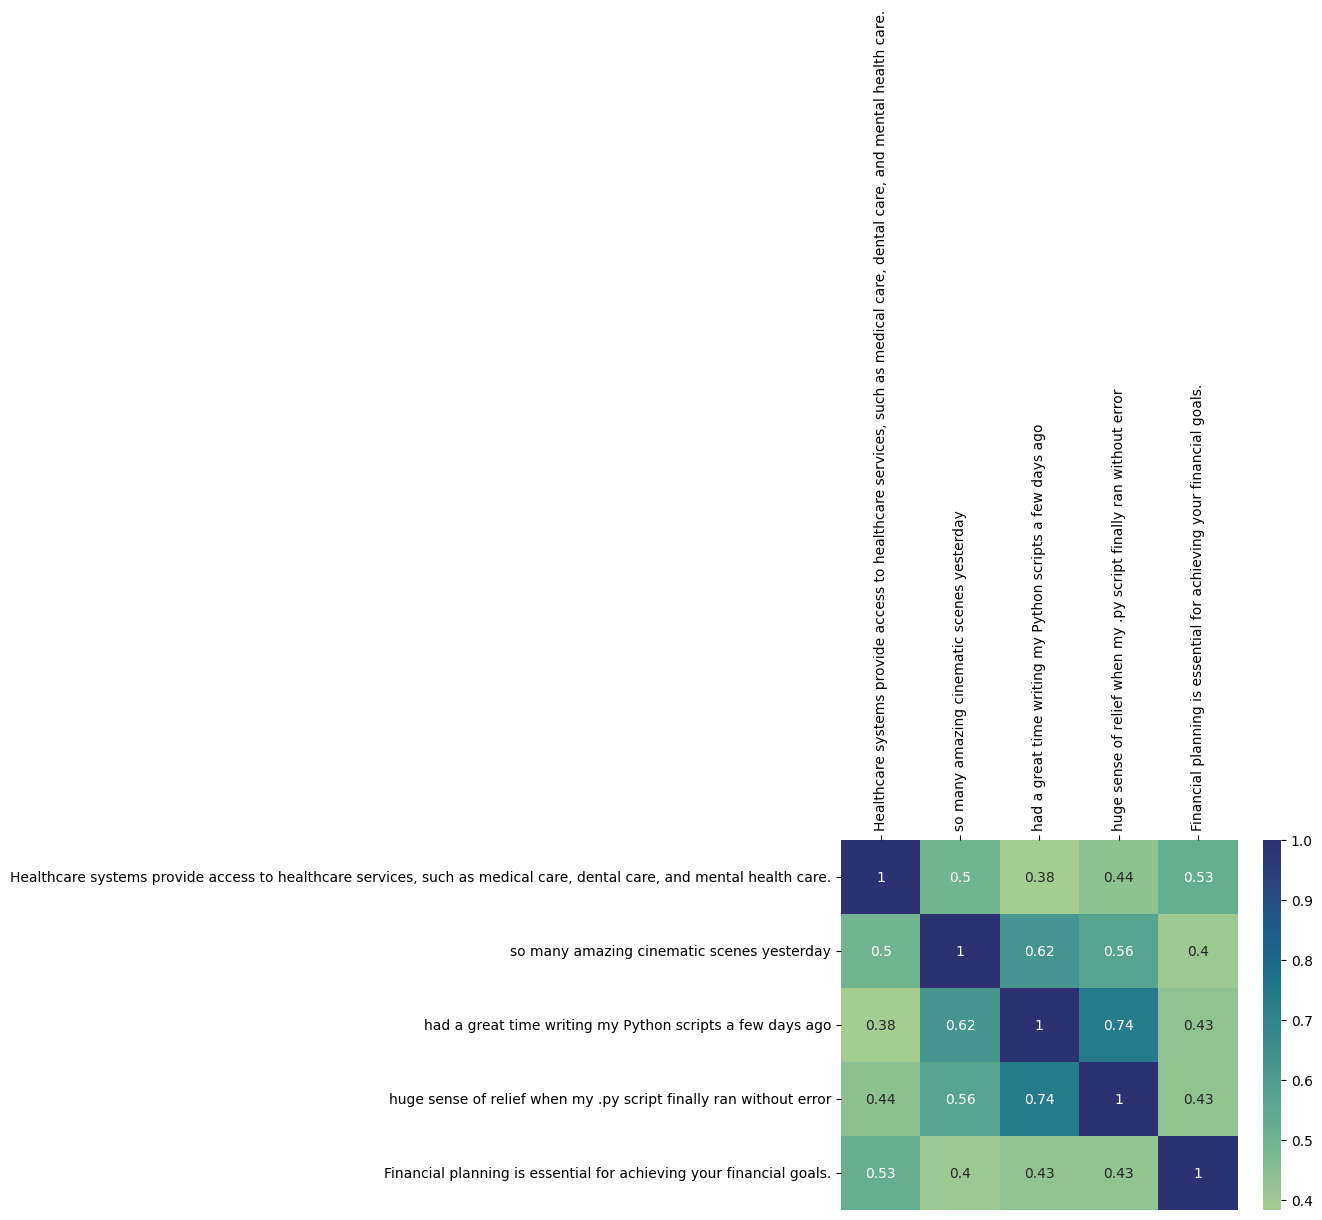

In [37]:
ax = sns.heatmap(df, annot=True, cmap="crest")
ax.xaxis.tick_top()
ax.set_xticklabels(text, rotation=90)

## Code generation with code-bison@001


The code generation model (Codey) from PaLM API that you will use in this notebook is code-bison@001. It is fine-tuned to follow natural language instructions to generate required code and is suitable for a variety of coding tasks, such as:

- writing functions
- writing classes
- web-apges
- unit tests
- docstrings
- code translations, and many more use-cases.

Currently it supports the following languages:
- C++
- C#
- Go
- GoogleSQL
- Java
- JavaScript
- Kotlin
- PHP
- Python
- Ruby
- Rust
- Scala
- Swift
- TypeScript

You can find our more details [here](https://cloud.google.com/vertex-ai/docs/generative-ai/code/code-models-overview).

### Load model

### Model parameters for `code-bison@001`

You can customize how the PaLM API code generation behaves in response to your prompt by using the following parameters for `code-bison@001`:

 - `prefix`: it represents the beginning of a piece of meaningful programming code or a natural language prompt that describes code to be generated.
 - `temperature`: higher means more "creative" code responses. range: (0.0 - 1.0, default 0).
 - `max_output_tokens`: sets the max number of tokens in the output. range: (1 - 2048, default 2048)


### Hello Codey

In [38]:
code_generation_model = CodeGenerationModel.from_pretrained("code-bison@001")
prefix = "write a python function to do binary search"

response = code_generation_model.predict(prefix=prefix)

print(response.text)

```python
def binary_search(array, target):
  """
  Performs a binary search on the given array for the given target.

  Args:
    array: The array to search.
    target: The target value to search for.

  Returns:
    The index of the target value in the array, if found. Otherwise, -1.
  """

  # Check if the array is empty.
  if not array:
    return -1

  # Find the middle index of the array.
  middle_index = len(array) // 2

  # Check if the target value is equal to the middle element.
  if array[middle_index] == target:
    return middle_index

  # Check if the target value is less than the middle element.
  elif target < array[middle_index]:
    return binary_search(array[:middle_index], target)

  # Otherwise, the target value must be greater than the middle element.
  else:
    return binary_search(array[middle_index + 1:], target)
```


Try your own prompts
Some examples:
* write Go program to extract ip addresses from the text file
* write Java program that can extract pincodes from addresses
* write a standard SQL function that strips all non-alphabet characters from the string and encodes it to utf-8

In [ ]:
prefix = """
          """

response = code_generation_model.predict(prefix=prefix, max_output_tokens=1024)

print(response.text)

### Prompt templates

Prompt templates are useful if you have found a good way to structure your prompt that you can re-use. This can be also be helpful in limiting the open-endedness of freeform prompts. There are many ways to implement prompt templates, and below is just one example using f-strings. This way you can structure the prompts as per the expected funcationality of the code.

In [19]:
language = "C++ function"
file_format = "json"
extract_info = "names"
requirments = """
              - the name should be start with capital letters.
              - There should be no duplicate names in the final list.
              """

prefix = f"""Create a {language} to parse {file_format} and extract {extract_info} with the following requirements: {requirments}.
              """

response = code_generation_model.predict(prefix=prefix, max_output_tokens=1024)

print(response.text)

```c++
#include <iostream>
#include <string>
#include <vector>
#include <map>

using namespace std;

// This function parses a JSON string and extracts all of the names.
// The names are returned in a vector of strings.
vector<string> getNamesFromJson(string json) {
  // Create a map to store the names.
  map<string, bool> names;

  // Parse the JSON string.
  stringstream ss(json);
  json::value_parser<string> parser;
  while (ss >> parser) {
    // Get the name of the current object.
    string name = parser.get_name();

    // If the name is not already in the map, add it.
    if (!names.count(name)) {
      names[name] = true;
    }
  }

  // Create a vector to store the names.
  vector<string> namesList;

  // Add all of the names to the vector.
  for (map<string, bool>::iterator it = names.begin(); it != names.end(); it++) {
    namesList.push_back(it->first);
  }

  // Return the vector of names.
  return namesList;
}

int main() {
  // Get the JSON string from the user.
  cout 